<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from pypardiso import spsolve

#Some plot settings
%run plot_functions/plot_settings.py

# HM coupling in 1D -- rate form

## Strong form

\begin{align}
    0 &= \partial_z \dot{\sigma}_{zz} = 0\\
    0 &= n\beta_p \dot{p} + \partial_z (\dot{u}_z + q_z) = n\beta_p \dot{p} + \partial_z \dot{u}_z - \partial_z \left[ \frac{k}{\mu} \left( \partial_z p - \gamma_\text{w} \right) \right]
\end{align}

## Finite elements in 1D

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [2]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [3]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_node_ids_u(num_iterations,max_order):
    sequence = []
    last_element = 0

    for i in range(num_iterations):
        if i == 0:
            #el_tuple = [0, 1, 2]
            el_tuple = [x for x in range(max_order)]
        elif i == 1:
            #el_tuple = [2, 5, 6]
            el_tuple = [max_order-1,2*max_order-1]
            for j in range(2,max_order):
                el_tuple.append(el_tuple[-1]+1)
        else:
            #a = last_element
            #b = a + max_order-1
            #c = b + 1
            #el_tuple = [a, b, c]
            el_tuple = [last_element,last_element + max_order-1]
            for j in range(2,max_order):
                el_tuple.append(el_tuple[-1]+1)
        
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence

def generate_node_ids_p(num_iterations,max_order):
    sequence = []
    last_element = max_order  # Start with the first element as 3

    for i in range(num_iterations):
        if i == 0:
            #pair = (3, 4)
            el_tuple = [x for x in range(max_order,2*max_order-1)]
        else:
            #a = last_element
            #b = a + 3
            #pair = (a, b)
            el_tuple = [last_element, last_element+max_order]
            for j in range(2,max_order-1):
                el_tuple.append(el_tuple[-1]+1)
        
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence

def generate_mesh(domain_length,nelems,nodes_per_elem,eltype):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    if (eltype=='u'):
        node_ids = generate_node_ids_u(nelems,nodes_per_elem)
    elif (eltype=='p'):
        node_ids = generate_node_ids_p(nelems,nodes_per_elem+1)
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        node_start_id = (2*nodes_per_elem-2)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         node_ids[i]))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [4]:
number_of_elements = 20
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1,'p')
solution = np.append(solution_u,solution_p)

In [5]:
def split_sol(n_els, solution,max_order):
    sol_u = np.array([])
    sol_p = np.array([])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(n_els,max_order) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(n_els,max_order) for item in sublist])
    return solution[n_ids_u], solution[n_ids_p]

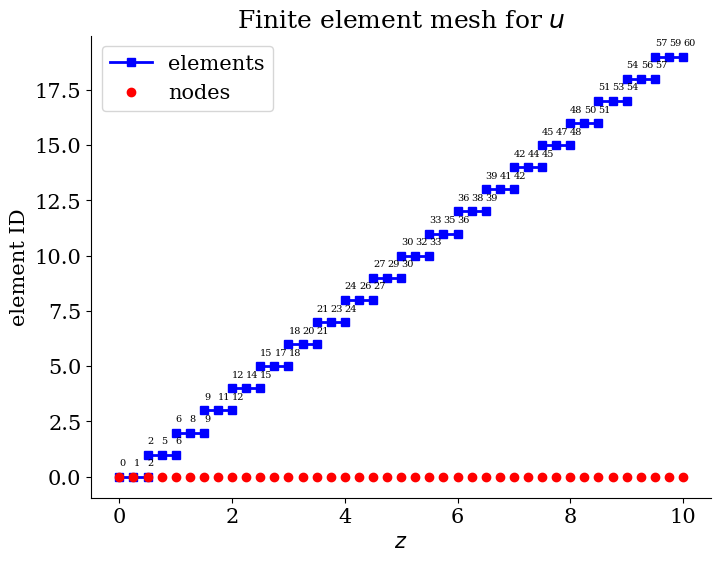

In [6]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $u$')
for i,elem in enumerate(elements_u):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_u, [0]*len(nodes_u), 'ro ', label='nodes')
plt.legend();

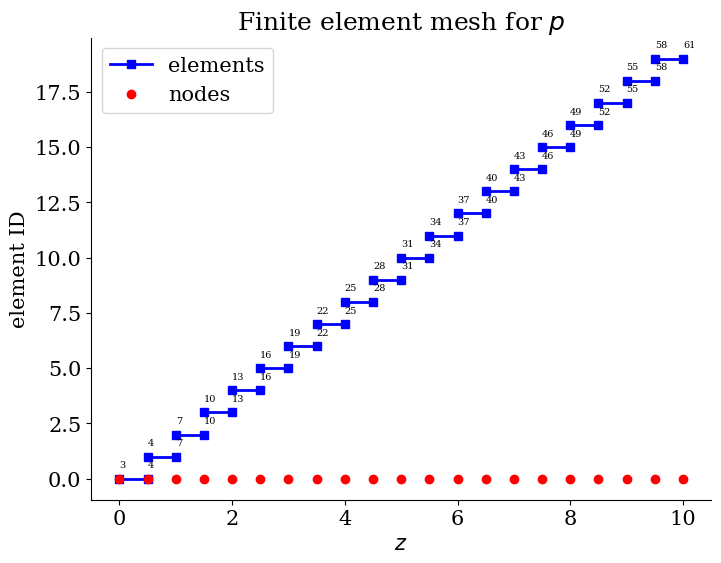

In [7]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $p$')
for i,elem in enumerate(elements_p):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_p, [0]*len(nodes_p), 'ro ', label='nodes')
plt.legend();

In [8]:
#N
def shape_function(element_order,xi):
    if (element_order == 1):
            return np.array([1])
    elif (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
    elif (element_order == 4): #-1, -1/3, 1/3, 1
            return np.array([9/16*(1-xi)*(xi**2 - 1/9),
                            27/16*(xi**2-1)*(xi-1/3),
                            27/16*(1-xi**2)*(xi+1/3),
                            9/16*(xi+1)*(xi**2-1/9)])
        
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 1):
            return np.array([0])
    elif (element_order == 2): #-1,1
        return np.array([-0.5, 0.5])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])
    elif (element_order == 4): #-1, -1/3, 1/3, 1
            return np.array([-27*xi**2/16 + 9*xi/8 + 1/16,
                            81/16*xi**2 - 9/8 * xi - 27/16, 
                            -81/16*xi**2 - 9/8 * xi +27/16,
                            27*xi**2/16 + 9*xi/8 - 1/16])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac

## Local assember

In [9]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    return 1e-11/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [10]:
def local_assembler_res_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt,fac=1):
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    res_loc = np.zeros(order_u + order_p)
    K_loc = np.zeros((order_u + order_p,order_u + order_p))
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(order_u,xi)
        N_p = shape_function(order_p,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(0)
        k_over_mu = Conductivity(0)
        beta = Compressibility(0)
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p))
        #print(q_z)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        s_z_prev = E * np.dot(dN_u_dX,sol_u_prev) - np.dot(N_p,sol_p_prev)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
           
        res_u = dN_u_dX*(s_z - s_z_prev)/dt
        res_p = dN_p_dX*q_z - N_p * (delta_e_vol + beta * delta_p)/dt
        
        #assembly of local Jac
        K_loc += np.block([[np.outer(dN_u_dX,dN_u_dX)*E/dt, -np.outer(dN_u_dX,N_p)/dt],
                           [-np.outer(N_p,dN_u_dX)/dt, -np.outer(dN_p_dX,dN_p_dX)*k_over_mu - np.outer(N_p,N_p)*beta/dt]]) * w * detJ
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return K_loc, res_loc

In [11]:
elem_u = elements_u[1]
elem_p = elements_p[1]

IDs_u = elem_u._line_element__global_ids
IDs_p = elem_p._line_element__global_ids
        #
el_sol_u = np.array([solution[IDs_u[i]] for i in range(len(IDs_u))])
el_sol_p = np.array([solution[IDs_p[i]] for i in range(len(IDs_p))])

In [13]:
K2,r2 = local_assembler_res_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,0.5)
print(K2)
print(r2)
np.linalg.cond(K2)
#np.linalg.det(K2)

[[ 9.33333333e+08 -1.06666667e+09  1.33333333e+08  1.66666667e+00
   3.33333333e-01]
 [-1.06666667e+09  2.13333333e+09 -1.06666667e+09 -1.33333333e+00
   1.33333333e+00]
 [ 1.33333333e+08 -1.06666667e+09  9.33333333e+08 -3.33333333e-01
  -1.66666667e+00]
 [ 1.66666667e+00 -1.33333333e+00 -3.33333333e-01 -2.00666667e-08
   1.99666667e-08]
 [ 3.33333333e-01  1.33333333e+00 -1.66666667e+00  1.99666667e-08
  -2.00666667e-08]]
[0. 0. 0. 0. 0.]


6.27450980392157e+17

Condition number exponents:  [18.27470104 33.0311487  18.27469901 18.27468062 18.27449673 18.27266211
 40.82279666 18.10720997 17.7975798  17.7975798  17.7975798  17.7975798
 17.7975798  17.7975798 ]


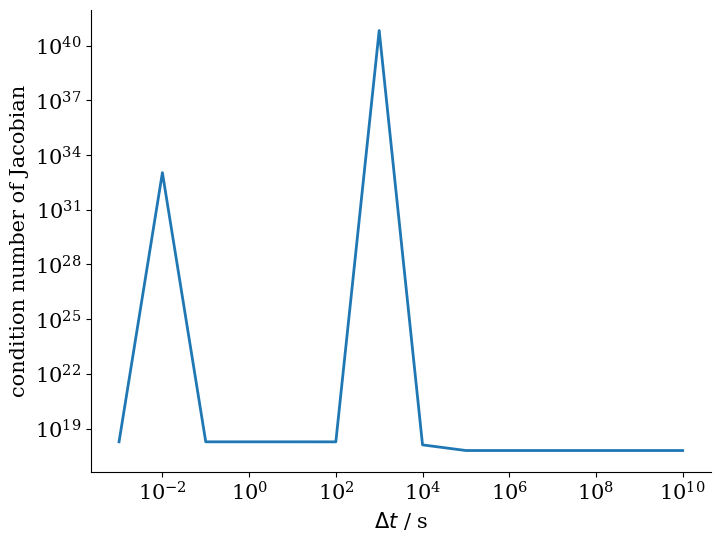

In [14]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    return 1e-17/1e-3

def Compressibility(z):
    return 5e-10*0.4

dts = np.logspace(-3,10,14)
conds = dts*0
for i,dt in enumerate(dts):
    K,r = local_assembler_res_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,dt)
    conds[i] = np.linalg.cond(K)
plt.plot(dts,conds)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta t$ / s')
plt.ylabel('condition number of Jacobian')
print("Condition number exponents: ", np.log10(conds))

Symmetric, but ill-conditioned, analytical Jacobian confirmed numerically (and more stable).

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [15]:
def global_assembler(elements_u,elements_p,solution,solution_prev,dt,f=local_assembler_res_Jac):
    K_glob = np.zeros((len(solution),len(solution)))
    b_glob = np.zeros(len(solution))
    for i,elem in enumerate(elements_u):
        #DOF table
        IDs_u = elem._line_element__global_ids
        IDs_p = elements_p[i]._line_element__global_ids
        #
        el_sol_u = np.array([solution[IDs_u[i]] for i in range(len(IDs_u))])
        el_sol_p = np.array([solution[IDs_p[i]] for i in range(len(IDs_p))])
        el_sol_u_prev = np.array([solution_prev[IDs_u[i]] for i in range(len(IDs_u))])
        el_sol_p_prev = np.array([solution_prev[IDs_p[i]] for i in range(len(IDs_p))])
        K_i, b_i = f(elem,elements_p[i],el_sol_u,el_sol_p,el_sol_u_prev,el_sol_p_prev,dt)
        for j in range(len(IDs_u)):
            b_glob[IDs_u[j]] += b_i[j]
            for k in range(len(IDs_u)):
                K_glob[IDs_u[j],IDs_u[k]] += K_i[j,k]
        for j in range(len(IDs_p)):
            b_glob[IDs_p[j]] += b_i[j+len(IDs_u)]
            for k in range(len(IDs_p)):
                K_glob[IDs_p[j],IDs_p[k]] += K_i[j+len(IDs_u),k+len(IDs_u)]
            
    return K_glob, b_glob

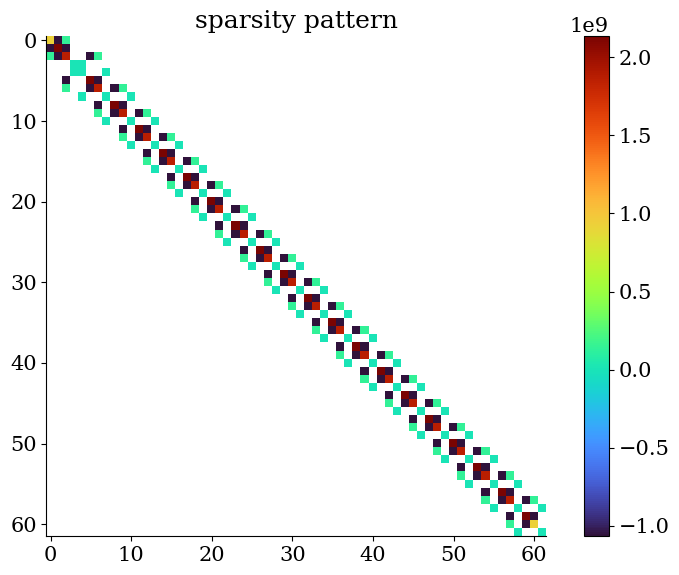

In [16]:
K, f = global_assembler(elements_u,elements_p,solution,solution*1.1,0.5)
plt.imshow(K, cmap='turbo',alpha=np.where(K==0,0.,1.))
plt.colorbar()
plt.title('sparsity pattern')
plt.tight_layout()

## Application of boundary conditions

Now we apply the natural (Neumann, nodal force) and the essential (Dirichlet, nodal displacement) boundary conditions.

In [17]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

A Dirichlet boundary condition is introduced via

$b_0 \leftarrow K_{0,0}(u_0 - \bar{u})$ so that $\Delta u_0 = \bar{u} - u_0$ and matrix condition number is not changed.

$b_{i \neq 0} \leftarrow b_{i\neq 0} - K_{i,0} (u_0 - \bar{u})$

$K_{0,i\neq 0} = K_{i\neq 0,0} \leftarrow 0$ 

This preserves $K_{ij} = K_{ji}$

In [18]:
#adapted to incremental scheme
def apply_Dirichlet_bc(K_glob,b_glob,solution,node_id,value):
    c = K_glob[node_id,node_id]
    if c == 0:
        c = 1
    target = solution[node_id] - value
    
    #for i in range(len(b_glob)):
    b_glob[:] -= K_glob[:,node_id] * target
    b_glob[node_id] = c*target #no increment
    K_glob[node_id,:] = 0.
    K_glob[:,node_id] = 0.
    
    K_glob[node_id,node_id] = c

    #solution[node_id] = value
    return K_glob, b_glob

In [19]:
def converged(inc_u,inc_p):
    n_u = np.linalg.norm(inc_u,np.inf)#np.linalg.norm(inc_u)/len(inc_u)
    n_p = np.linalg.norm(inc_p,np.inf)#np.linalg.norm(inc_p)/len(inc_p)
    #print(n_u, n_p)
    if (n_u <= 1e-6 and n_p <= 1e0):
        return True
    else:
        return False

In [20]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u),elements_u[0]._line_element__nnodes) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u),elements_u[0]._line_element__nnodes) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],(p_top(times[-1])-p_top(times[-2]))/dt) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        sK = sp.sparse.csr_matrix(K) 
        inc = spsolve(sK,-f)
        #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        #lu, piv = sp.linalg.lu_factor(K)
        #inc = sp.linalg.lu_solve((lu, piv), -f)
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],(p_top(times[-1])-p_top(times[-2]))/dt) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            sK = sp.sparse.csr_matrix(K) 
            inc = spsolve(sK,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #lu, piv = sp.linalg.lu_factor(K)
            #inc = sp.linalg.lu_solve((lu, piv), -f)
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

## Consolidation

As in Terzaghi scripts.

In [21]:
number_of_elements = 10
L = 10.
nodes_per_element = 4

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1,'p')
solution = np.append(solution_u,solution_p)

In [22]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u),elements_u[0]._line_element__nnodes) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u),elements_u[0]._line_element__nnodes) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],(p_top(times[-1])-p_top(times[-2]))/dt)
        #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
        #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        #for k in range(len(n_ids_u)):
        #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        sK = sp.sparse.csr_matrix(K) 
        inc = spsolve(sK,-f)
        #inc = sp.sparse.linalg.bicg(K, -f)[0]
        #lu, piv = sp.linalg.lu_factor(K)
        #inc = sp.linalg.lu_solve((lu, piv), -f)
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],(p_top(times[-1])-p_top(times[-2]))/dt)
            #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
            #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            #for k in range(len(n_ids_u)):
            #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            sK = sp.sparse.csr_matrix(K) 
            inc = spsolve(sK,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #lu, piv = sp.linalg.lu_factor(K)
            #inc = sp.linalg.lu_solve((lu, piv), -f)
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [23]:
def Stiffness(z):
    return 5e6

def gamma_r(z):
    return 0

def gamma_w():
    return 0

def Conductivity(z):
    return 1e-5 / 1e4 # k/mu = k_f/gamma_w

def Compressibility(z):
    return 5e-10*0.4

In [27]:
day_in_sec = 86400
p_top = lambda t: 2e5*np.heaviside(t,0)
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec/2,day_in_sec*3,p_top)

Solving time step 1.
Performed 15 iterations.
Solving time step 2.
Performed 14 iterations.
Solving time step 3.
Performed 12 iterations.
Solving time step 4.
Performed 10 iterations.
Solving time step 5.
Performed 8 iterations.
Solving time step 6.
Performed 4 iterations.


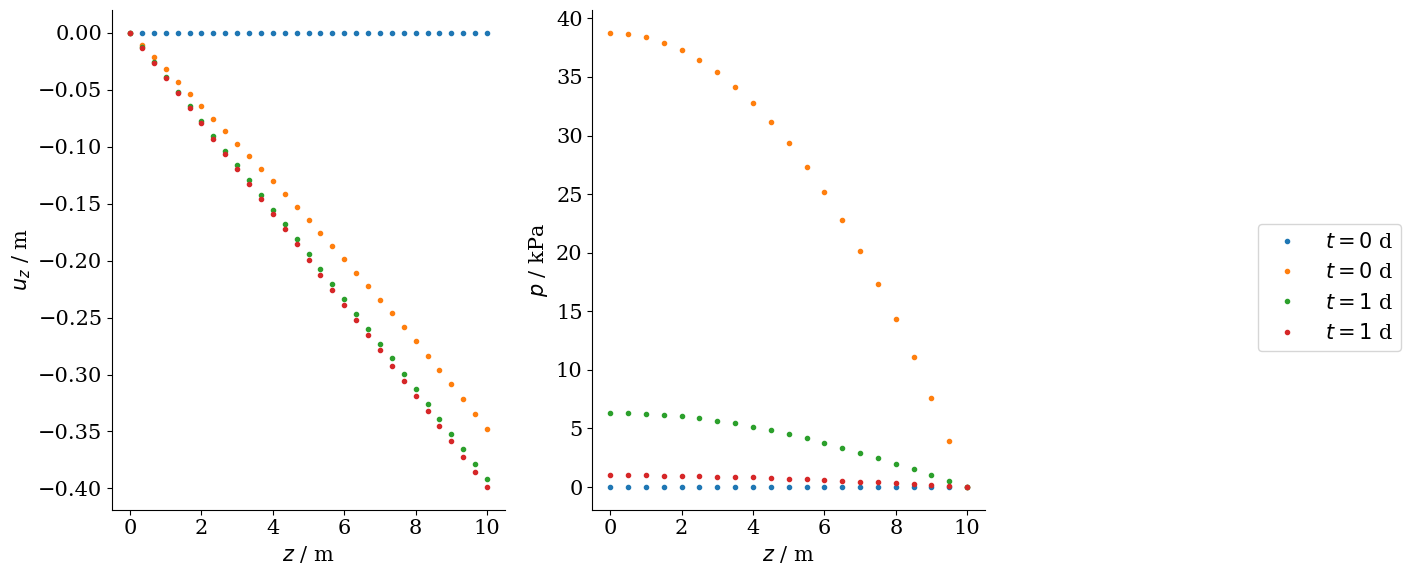

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ttimes = [0,1,2,3]#,30]#,200,-1]
for i in ttimes:
    t = times[i]
    sol_u, sol_p = split_sol(len(elements_u), sols[i],nodes_per_element)
    ax[0].plot(nodes_u, sol_u, label='$t = %i$ d' % (t/day_in_sec), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, ls='', marker='.')

ax[0].set_xlabel('$z$ / m')
ax[1].set_xlabel('$z$ / m')
ax[0].set_ylabel('$u_z$ / m')
ax[1].set_ylabel('$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend